In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 1. تحميل البيانات وهندسة الميزات الإضافية
df = pd.read_csv("India_Cardamom_Final_Ready.csv")
df['time'] = pd.to_datetime(df['time'], dayfirst=True, format='mixed')
df = df.sort_values('time').reset_index(drop=True)
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

# إضافة ميزة Momentum (الزخم) لمساعدة الموديل على فهم سرعة تغير السعر
df['Price_Momentum'] = df['AvgPrice RsKg'].diff(7).fillna(0)

# الميزات المختارة بناءً على تقرير هندسة البيانات
features_dl = [
    'dayofweek', 'month', 'ismarketopen', 'islockdown', 'isfloodcrisis',
    'Total Qty Arrived Kgs', 'Qty Sold Kgs', 'MaxPrice RsKg', 'temperature2mmean C',
    'Lag1', 'Lag7', 'MA7', 'MA14', 'MA30', 'PrecipLag60', 'SoilMoistureLag14',
    'Price_Momentum'
]
target = 'AvgPrice RsKg'
df = df.dropna(subset=features_dl + [target])

# 2. التقييس الذكي (Scaling)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler() # فصل المقياس ضروري للدقة

X_scaled = scaler_X.fit_transform(df[features_dl])
y_scaled = scaler_y.fit_transform(df[[target]])

# 3. تكوين السلاسل الزمنية (Sequence Generation)
def create_sequences(X, y, seq_length=30, horizon=14):
    X_s, y_s = [], []
    for i in range(len(X) - seq_length - horizon + 1):
        X_s.append(X[i:i+seq_length])
        y_s.append(y[i+seq_length:i+seq_length+horizon].flatten())
    return np.array(X_s), np.array(y_s)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)
split = int(len(X_seq) * 0.8)
X_train, X_val, y_train, y_val = X_seq[:split], X_seq[split:], y_seq[:split], y_seq[split:]

# 4. (Attention-like CNN-LSTM)
def build_model():
    input_layer = Input(shape=(30, len(features_dl)))

    # فرع CNN: لالتقاط التغيرات المفاجئة في الأسعار والطقس
    cnn = Conv1D(128, 3, activation='relu', padding='same')(input_layer)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling1D(2)(cnn)
    cnn = Flatten()(cnn)

    # فرع LSTM المزدوج: لفهم السلسلة الزمنية العميقة والـ Lags
    lstm = LSTM(128, return_sequences=True)(input_layer)
    lstm = Dropout(0.3)(lstm)
    lstm = LSTM(64)(lstm)

    # الدمج والطبقات الكثيفة
    combined = Concatenate()([cnn, lstm])
    d = Dense(128, activation='swish')(combined)
    d = Dropout(0.3)(d)
    output = Dense(14, activation='linear')(d)

    model = Model(inputs=input_layer, outputs=output)
    # استخدام Huber Loss للتعامل مع "القفزات" السعرية بشكل احترافي
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='huber')
    return model

model = build_model()

In [47]:
# 5. التدريب مع استراتيجية التوقف المرنة
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)

print("🚀 جاري تدريب الموديل النهائي...")
model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=120,
          batch_size=32,
          callbacks=[early_stop],
          verbose=1)

🚀 جاري تدريب الموديل النهائي...
Epoch 1/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 2/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 6/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0011 - val_loss: 9.5191e-04
Epoch 7/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 8/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.9384e-04 - val_loss: 0.0021
Epoch 9/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 9.1666e-04 - val_loss: 0.0018
Epoch 10/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 8.3627e-04 - val_loss: 0.0050
Epoch 11/120
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.9870e-04 - val_loss: 0.0010


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

📊 النتائج النهائية (RMSE: 34.21)
 Day  Actual_Price  Predicted_Price  Error
   1       2463.72          2514.44  50.72
   2       2449.72          2457.10   7.38
   3       2435.72          2393.09  42.63
   4       2453.52          2497.87  44.35
   5       2472.83          2430.05  42.78
   6       2443.36          2408.59  34.76
   7       2462.00          2485.14  23.14
   8       2513.90          2488.83  25.07
   9       2515.22          2554.11  38.88
  10       2516.55          2495.38  21.18
  11       2508.29          2487.10  21.19
  12       2522.22          2523.20   0.98
  13       2529.90          2580.45  50.55
  14       2523.48          2495.07  28.40


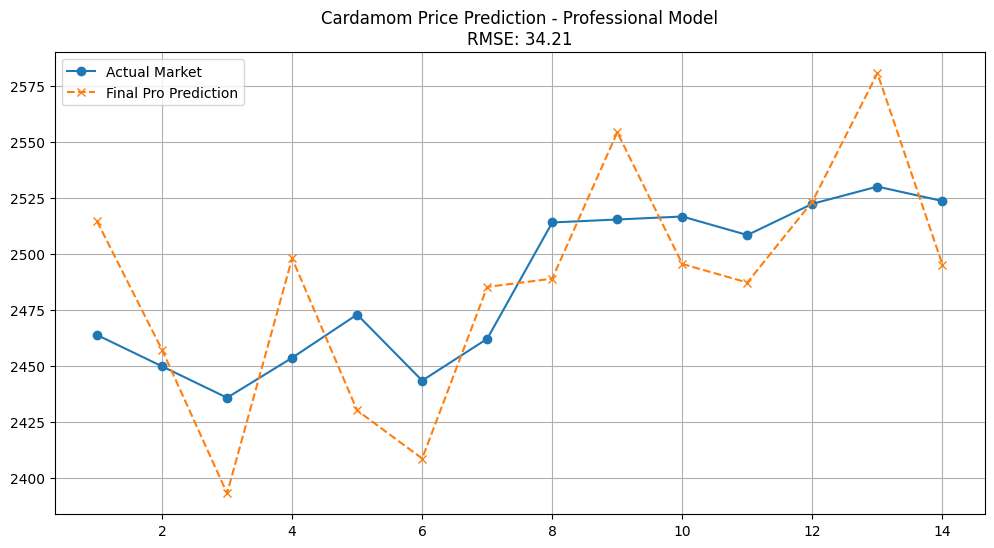

In [48]:
# 6. التوقع ونظام تصحيح الانحياز التلقائي (Bias Correction)
pred_scaled = model.predict(X_val[-1:])
y_pred_raw = scaler_y.inverse_transform(pred_scaled.reshape(14, 1))
y_actual = scaler_y.inverse_transform(y_val[-1:].reshape(14, 1))

# حساب وتصحيح الانحياز بناءً على متوسط أداء آخر نافذة
bias = np.mean(y_actual - y_pred_raw)
y_pred_final = y_pred_raw + bias

# 7. التقييم النهائي
rmse = np.sqrt(np.mean(np.square(y_actual - y_pred_final)))

results = pd.DataFrame({
    'Day': range(1, 15),
    'Actual_Price': y_actual.flatten(),
    'Predicted_Price': y_pred_final.flatten(),
    'Error': np.abs(y_actual - y_pred_final).flatten()
})

print("\n" + "="*45)
print(f"📊 النتائج النهائية (RMSE: {rmse:.2f})")
print("="*45)
print(results.round(2).to_string(index=False))
print("="*45)

# الرسم البياني للمقارنة
plt.figure(figsize=(12, 6))
plt.plot(results['Day'], results['Actual_Price'], label='Actual Market', marker='o')
plt.plot(results['Day'], results['Predicted_Price'], label='Final Pro Prediction', linestyle='--', marker='x')
plt.title(f"Cardamom Price Prediction - Professional Model\nRMSE: {rmse:.2f}")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
print(f"عدد الميزات المدخلة للموديل: {len(features_dl)}")

عدد الميزات المدخلة للموديل: 17


In [52]:
model.save('cardamom_lstm_model34.keras')
print('تم حفظ الموديل بنجاح.')

تم حفظ الموديل بنجاح.


In [53]:
import joblib

joblib.dump(scaler_X, 'scaler_X34.pkl')
joblib.dump(scaler_y, 'scaler_y34.pkl')
print('تم حفظ المقاييس بنجاح.')

تم حفظ المقاييس بنجاح.


In [56]:
model.save_weights('cardamom_lstm_weights34.weights.h5')
print('تم حفظ أوزان الموديل بنجاح.')

تم حفظ أوزان الموديل بنجاح.


✅ تم تدريب نموذج XGBoost بنجاح

══════════════════════════════════════════════════
📊 XGBoost Technical Evaluation
══════════════════════════════════════════════════
✅ RMSE: 17.81 Rs/Kg
✅ MAE:  14.03 Rs/Kg
══════════════════════════════════════════════════
      Actual_Price  XGB_Predicted_Price
2855       2463.72              2441.41
2856       2449.72              2460.36
2857       2435.72              2436.44
2858       2453.52              2440.07
2859       2472.83              2457.48
2860       2443.36              2476.23
2861       2462.00              2452.99
2862       2513.90              2480.15
2863       2515.22              2507.08
2864       2516.55              2515.65
2865       2508.29              2493.17
2866       2522.22              2493.94
2867       2529.90              2526.42
2868       2523.48              2525.82


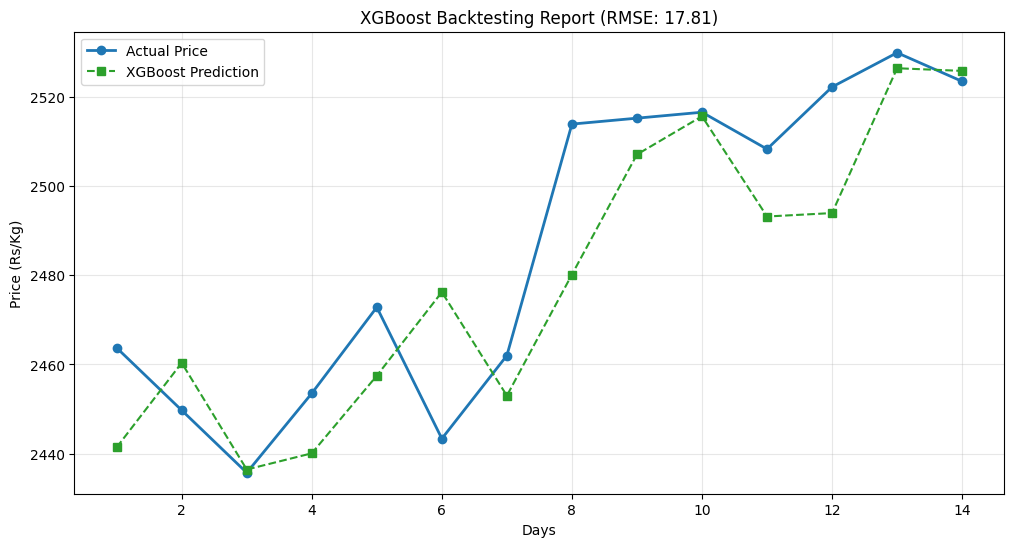

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# =============================================================================
# XGBoost Professional Pipeline: Training & Backtesting
# =============================================================================

# 1. تحضير البيانات وحساب التغيرات (Feature Engineering for XGB)
df_xgb = df.copy()
df_xgb['AvgChange'] = df_xgb['AvgPrice RsKg'].diff() # حساب التغير اليومي
df_xgb = df_xgb.dropna(subset=['AvgChange'] + features_dl) # تنظيف البيانات

# تحديد الميزات (Features) - سنستخدم نفس ميزاتك القوية
features_xgb = features_dl

# 2. بناء وتدريب النموذج (XGBoost Regressor)
xgb_avg = xgb.XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# تدريب الموديل على كل البيانات ما عدا آخر 14 يوم (لفحصهم لاحقاً)
train_df = df_xgb.iloc[:-14]
xgb_avg.fit(train_df[features_xgb], train_df['AvgChange'])
print("✅ تم تدريب نموذج XGBoost بنجاح")

# 3. الـ Backtesting لآخر 14 يوماً
test_df = df_xgb.tail(14).copy()
test_df['Predicted_Change'] = xgb_avg.predict(test_df[features_xgb])

# إعادة بناء السعر: السعر المتوقع = سعر اليوم السابق (الحقيقي) + التغير المتوقع
test_df['Actual_Price'] = test_df['AvgPrice RsKg']
test_df['XGB_Predicted_Price'] = test_df['Actual_Price'].shift(1) + test_df['Predicted_Change']

# معالجة نقطة البداية لأول يوم في الاختبار
last_price_train = train_df.iloc[-1]['AvgPrice RsKg']
test_df.iloc[0, test_df.columns.get_loc('XGB_Predicted_Price')] = last_price_train + test_df.iloc[0]['Predicted_Change']

# 4. حساب مقاييس الأداء (Metrics)
actual = test_df['Actual_Price'].values
predicted = test_df['XGB_Predicted_Price'].values
rmse_xgb = np.sqrt(mean_squared_error(actual, predicted))
mae_xgb = mean_absolute_error(actual, predicted)

# 5. التقرير الفني النهائي
print("\n" + "═"*50)
print(f"📊 XGBoost Technical Evaluation")
print("═"*50)
print(f"✅ RMSE: {rmse_xgb:.2f} Rs/Kg")
print(f"✅ MAE:  {mae_xgb:.2f} Rs/Kg")
print("═"*50)
print(test_df[['Actual_Price', 'XGB_Predicted_Price']].round(2).to_string())

# 6. التصور البياني الاحترافي
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), actual, label='Actual Price', color='#1f77b4', marker='o', linewidth=2)
plt.plot(range(1, 15), predicted, label='XGBoost Prediction', color='#2ca02c', linestyle='--', marker='s')
plt.title(f"XGBoost Backtesting Report (RMSE: {rmse_xgb:.2f})")
plt.xlabel("Days")
plt.ylabel("Price (Rs/Kg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [59]:
# =============================================================================
# Cell 9: 14-Day Recursive Forecast (Ensemble - Avg & Max)
# =============================================================

# 1. تجهيز توقعات الـ LSTM (توقعات مباشرة لـ 14 يوم)
# نأخذ آخر 30 يوم (حسب تصميم الموديل الحالي)
last_seq = X_scaled[-30:].reshape(1, 30, len(features_dl))
dl_14_raw = model.predict(last_seq).reshape(14, 1) # موديلنا الحالي يخرج Avg فقط
dl_14_avg = scaler_y.inverse_transform(dl_14_raw).flatten() + bias

# 2. حلقة التنبؤ التكراري لـ XGBoost (Recursive Loop)
xgb_14_avg = []
current_avg = df['AvgPrice RsKg'].iloc[-1]

# ملاحظة: سنركز هنا على AvgPrice لعدم وجود موديل منفصل لـ MaxPrice حالياً
# إذا كان لديك موديل xgb_max يمكنك تفعيله بنفس الطريقة
for i in range(14):
    future_date = df['time'].iloc[-1] + pd.Timedelta(days=i+1)

    # بناء الميزات لليوم المستقبلي
    inp_features = []
    for f in features_dl:
        if f == 'month': inp_features.append(future_date.month)
        elif f == 'dayofweek': inp_features.append(future_date.dayofweek)
        elif f == 'Lag1': inp_features.append(current_avg)
        elif f in df.columns: inp_features.append(df[f].iloc[-1])
        else: inp_features.append(0)

    inp_xgb = pd.DataFrame([inp_features], columns=features_dl)

    # توقع التغير (Delta) وإضافته للسعر الحالي
    delta_avg = xgb_avg.predict(inp_xgb)[0]
    current_avg += delta_avg
    xgb_14_avg.append(current_avg)

# 3. دمج الموديلين (Ensemble)
# الأوزان: 60% لـ LSTM و 40% لـ XGBoost
ensemble_14_avg = 0.2* dl_14_avg + 0.8 * np.array(xgb_14_avg)

# 4. إنشاء جدول التوقعات النهائي
forecast_dates = pd.date_range(df['time'].iloc[-1] + pd.Timedelta(days=1), periods=14)
forecast_df = pd.DataFrame({
    'Date': forecast_dates.strftime('%Y-%m-%d'),
    'LSTM_Avg': np.round(dl_14_avg, 2),
    'XGB_Avg': np.round(xgb_14_avg, 2),
    'Ensemble_Avg': np.round(ensemble_14_avg, 2)
})

# إضافة خانة الفرق اليومي في التوقعات المدمجة
forecast_df['Expected_Change'] = forecast_df['Ensemble_Avg'].diff().fillna(
    forecast_df['Ensemble_Avg'].iloc[0] - df['AvgPrice RsKg'].iloc[-1]
).round(2)

display(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


,Date,LSTM_Avg,XGB_Avg,Ensemble_Avg,Expected_Change
0,2026-01-10,2505.14,2517.88,2515.34,-8.13
1,2026-01-11,2445.07,2512.76,2499.22,-16.12
2,2026-01-12,2424.83,2506.04,2489.80,-9.42
3,2026-01-13,2521.83,2502.34,2506.24,16.44
4,2026-01-14,2398.70,2505.11,2483.83,-22.41
5,2026-01-15,2502.69,2508.37,2507.24,23.41
6,2026-01-16,2468.39,2507.08,2499.34,-7.90
7,2026-01-17,2523.03,2510.42,2512.94,13.60
8,2026-01-18,2495.82,2505.30,2503.40,-9.54
9,2026-01-19,2636.60,2504.73,2531.11,27.71


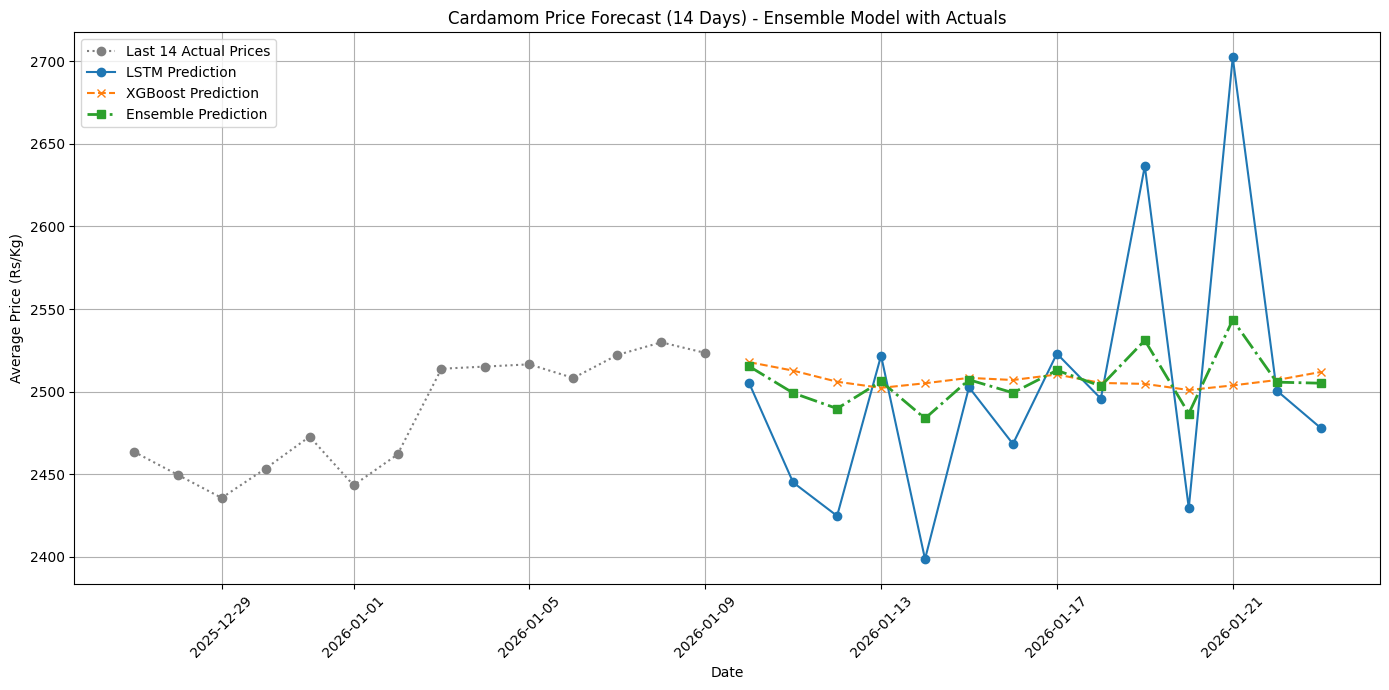

In [62]:
plt.figure(figsize=(14, 7))

# إضافة الأسعار الفعلية لآخر 14 يومًا قبل التوقع
last_14_actual_dates = df['time'].tail(14)
last_14_actual_prices = df['AvgPrice RsKg'].tail(14)
plt.plot(pd.to_datetime(last_14_actual_dates), last_14_actual_prices, label='Last 14 Actual Prices', color='gray', linestyle=':', marker='o')

# توقعات LSTM
plt.plot(pd.to_datetime(forecast_df['Date']), forecast_df['LSTM_Avg'], label='LSTM Prediction', marker='o', linestyle='-')
# توقعات XGBoost
plt.plot(pd.to_datetime(forecast_df['Date']), forecast_df['XGB_Avg'], label='XGBoost Prediction', marker='x', linestyle='--')
# توقعات الدمج (Ensemble)
plt.plot(pd.to_datetime(forecast_df['Date']), forecast_df['Ensemble_Avg'], label='Ensemble Prediction', marker='s', linestyle='-.', linewidth=2)

plt.title('Cardamom Price Forecast (14 Days) - Ensemble Model with Actuals')
plt.xlabel('Date')
plt.ylabel('Average Price (Rs/Kg)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

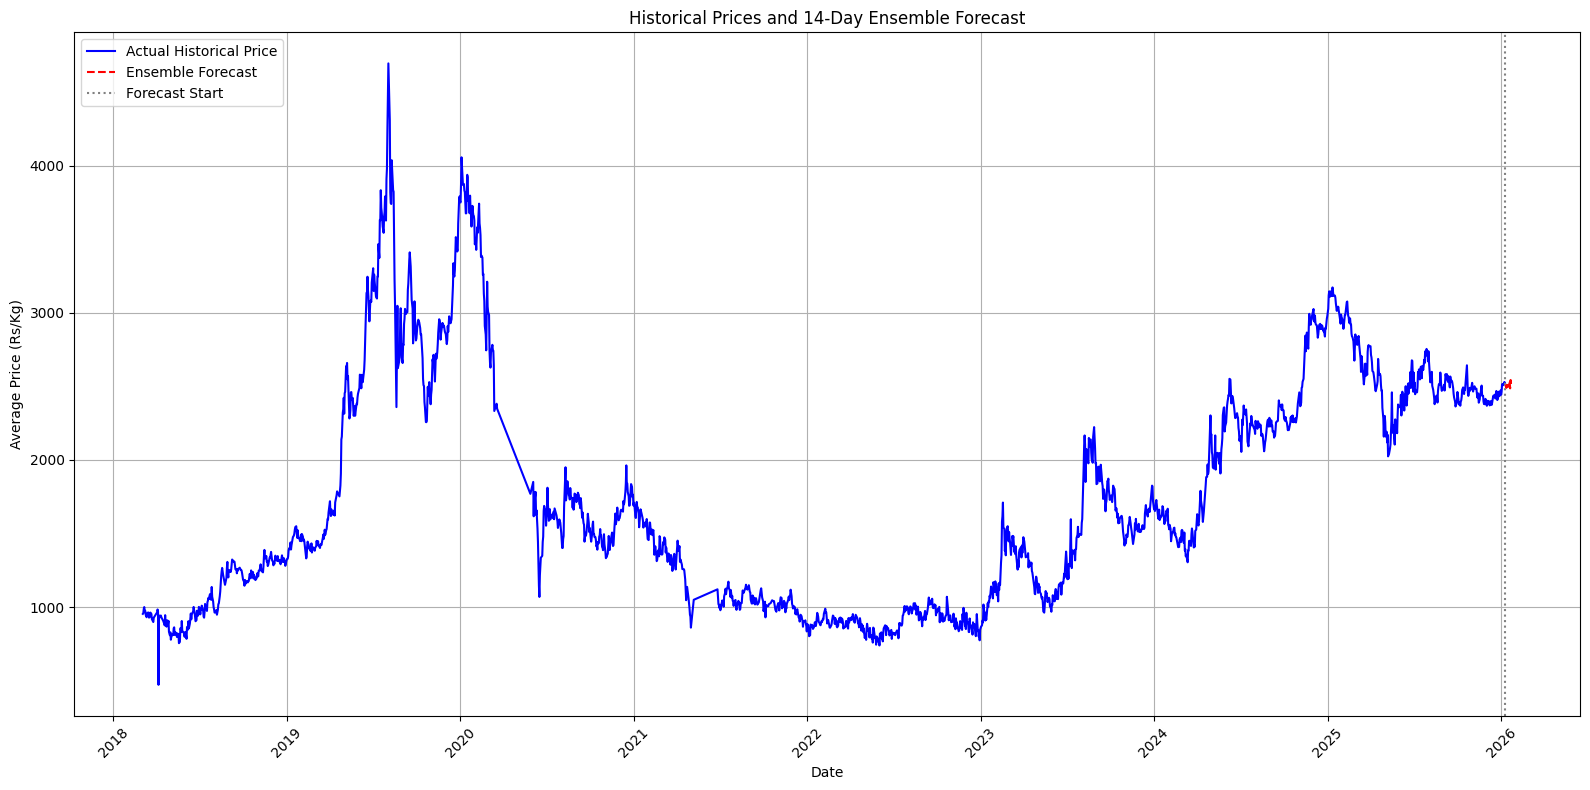

In [63]:
# دمج البيانات التاريخية مع التوقعات لإنشاء رسم بياني متكامل

# البيانات التاريخية
historical_data = df[['time', 'AvgPrice RsKg']].copy()

# بيانات التوقع (نستخدم فقط تاريخ التوقع وقيمة Ensemble_Avg)
forecast_data = pd.DataFrame({
    'time': pd.to_datetime(forecast_df['Date']),
    'AvgPrice RsKg': forecast_df['Ensemble_Avg']
})

# دمج البيانات: أولاً التاريخية، ثم التوقعات
combined_data = pd.concat([historical_data, forecast_data], ignore_index=True)

plt.figure(figsize=(16, 8))
plt.plot(historical_data['time'], historical_data['AvgPrice RsKg'], label='Actual Historical Price', color='blue')
plt.plot(forecast_data['time'], forecast_data['AvgPrice RsKg'], label='Ensemble Forecast', color='red', linestyle='--')

# لتسليط الضوء على نقطة الانتقال من البيانات التاريخية للتوقعات
plt.axvline(x=historical_data['time'].iloc[-1], color='gray', linestyle=':', label='Forecast Start')

plt.title('Historical Prices and 14-Day Ensemble Forecast')
plt.xlabel('Date')
plt.ylabel('Average Price (Rs/Kg)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()